In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

#### Code 3.1

$$Pr(vampire|positive) = \frac{Pr(positive|vampire) Pr(vampire)} {Pr(positive)}$$

$$Pr(positive) = Pr(positive|vampire) Pr(vampire) + Pr(positive|mortal) 1 − Pr(vampire)$$

In [3]:
PrPV = 0.95
PrPM = 0.01
PrV = 0.001
PrP = PrPV * PrV + PrPM * (1 - PrV)
PrVP = PrPV * PrV / PrP
PrVP

0.08683729433272395

#### Code 3.2 - 3.5

We are goint to use the same function we use on chapter 2 (code 2.3)

In [4]:
def posterior_grid_approx(grid_points=100, success=6, tosses=9):
    """
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = np.repeat(5, grid_points)  # uniform
    #prior = (p_grid >= 0.5).astype(int)  # truncated
    #prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

In [5]:
p_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

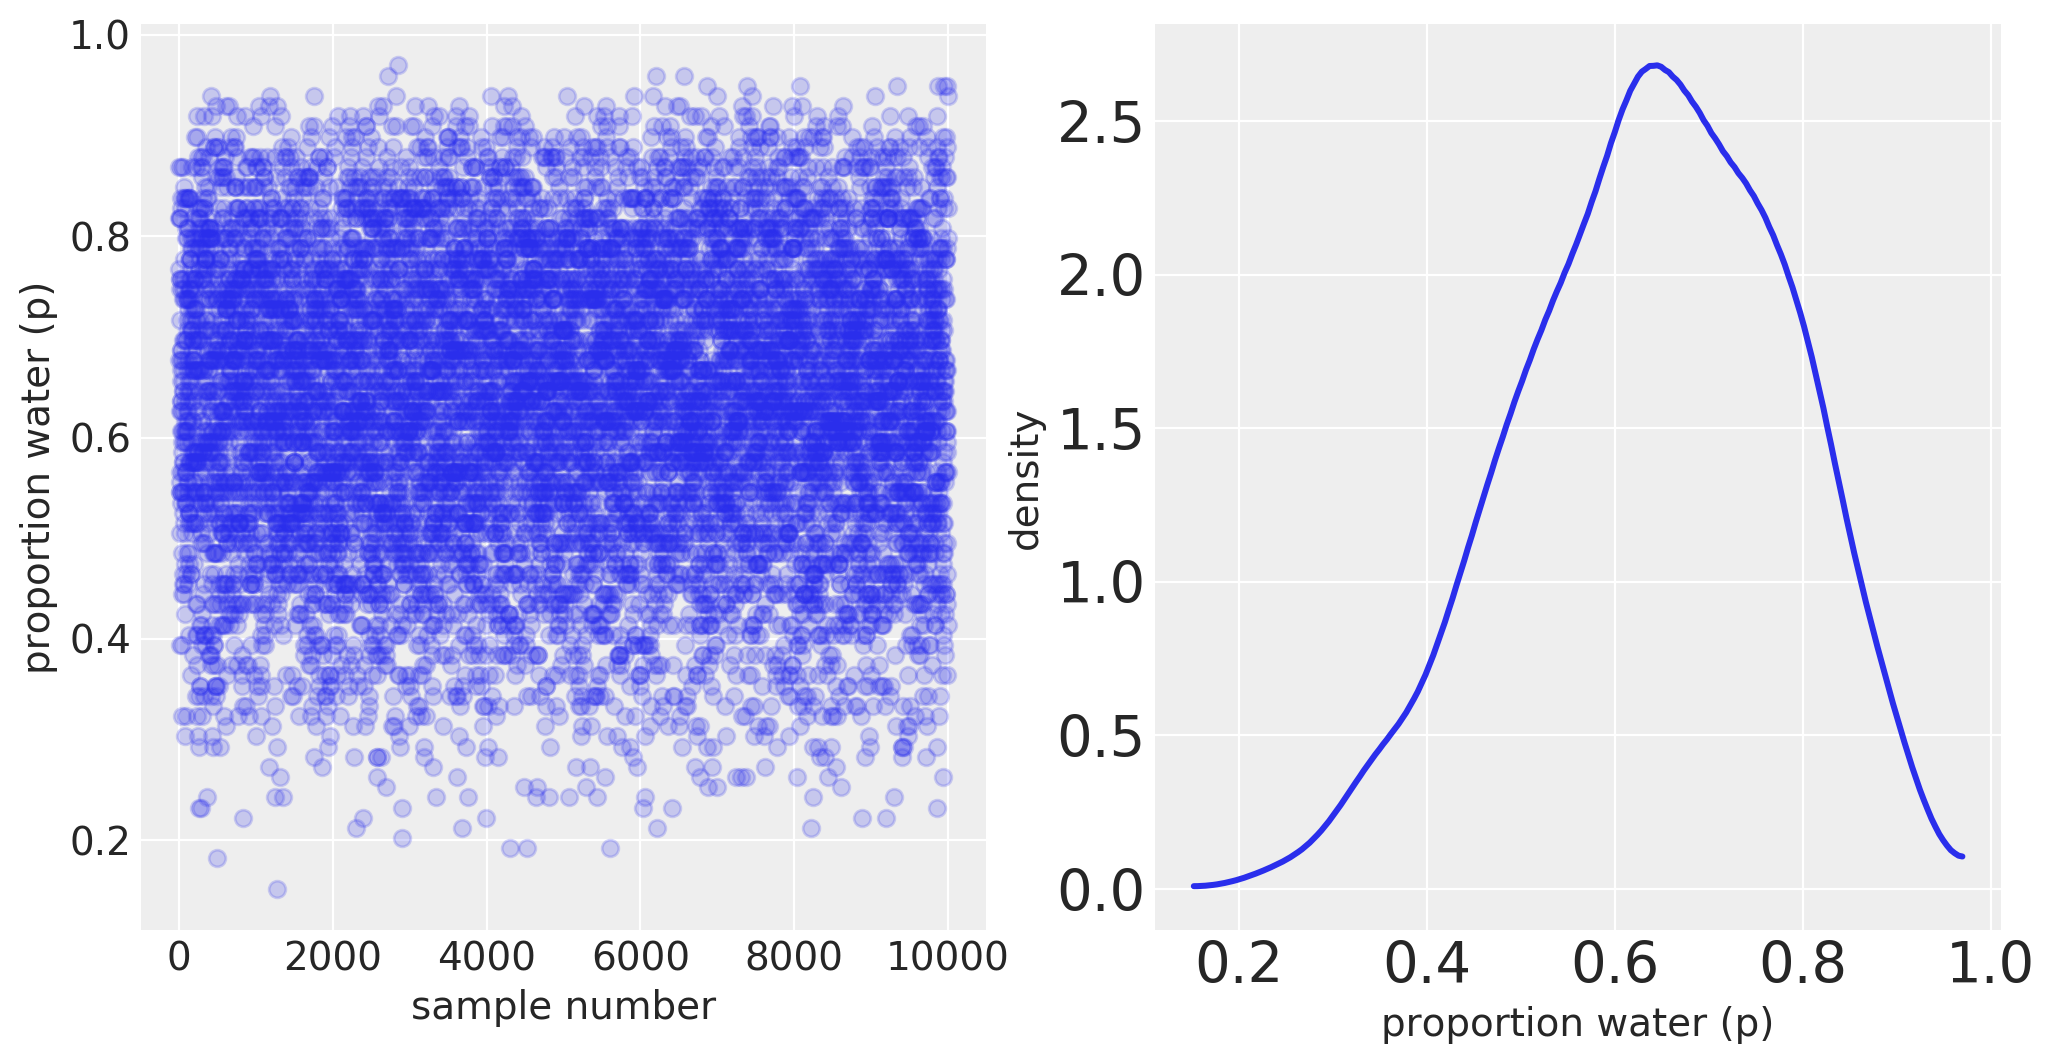

In [6]:
_, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))
ax0.plot(samples, 'o', alpha=0.2)
ax0.set_xlabel('sample number', fontsize=14)
ax0.set_ylabel('proportion water (p)', fontsize=14)
az.plot_kde(samples, ax=ax1)
ax1.set_xlabel('proportion water (p)', fontsize=14)
ax1.set_ylabel('density', fontsize=14);

#### Code 3.6

In [7]:
sum(posterior[ p_grid < 0.5 ])

0.17183313110747478

#### Code 3.7

In [8]:
sum( samples < 0.5 ) / 1e4

0.1712

#### Code 3.8

In [9]:
sum((samples > 0.5) & (samples < 0.75)) / 1e4

0.5989

#### Code 3.9

In [10]:
np.percentile(samples, 80)

0.7676767676767677

#### Code 3.10

In [11]:
np.percentile(samples, [10, 90])

array([0.44444444, 0.81818182])

#### Code 3.11

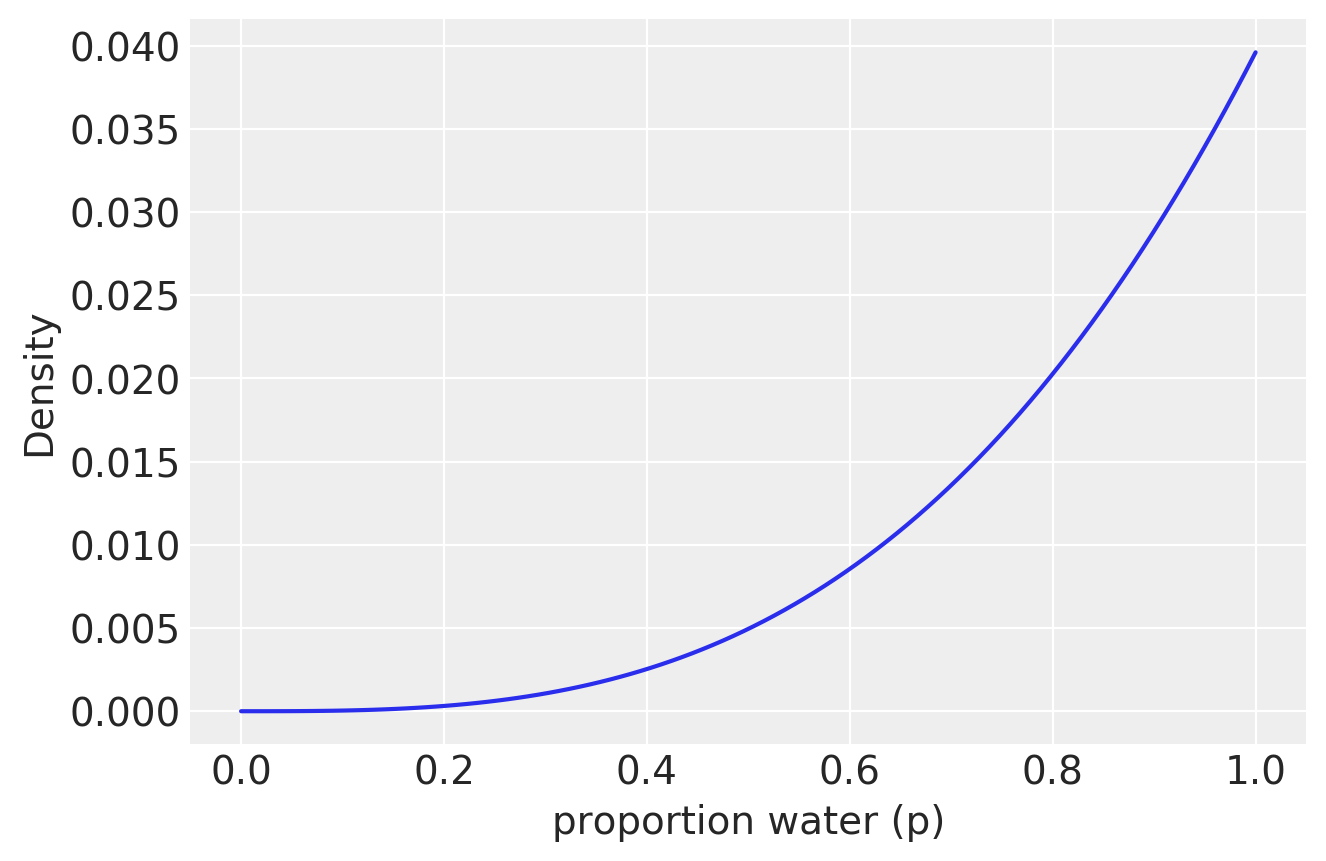

In [12]:
p_grid, posterior = posterior_grid_approx(success=3, tosses=3)
plt.plot(p_grid, posterior)
plt.xlabel('proportion water (p)', fontsize=14)
plt.ylabel('Density', fontsize=14);

#### Code 3.12

In [13]:
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)
np.percentile(samples, [25, 75])

array([0.70707071, 0.92929293])

#### Code 3.13

In [14]:
az.hpd(samples, credible_interval=0.5)

array([0.82828283, 0.98989899])

#### Code 3.14

In [15]:
p_grid[posterior == max(posterior)]

array([1.])

#### Code 3.15

In [16]:
stats.mode(samples)[0]

array([1.])

#### Code 3.16

In [17]:
np.mean(samples), np.median(samples)

(0.8014525252525253, 0.8383838383838385)

#### Code 3.17

In [18]:
sum(posterior * abs(0.5 - p_grid))

0.31626874808692995

#### Code 3.18 and 3.19

In [19]:
loss = [sum(posterior * abs(p - p_grid)) for p in p_grid]
p_grid[loss == min(loss)]

array([0.84848485])

#### Code 3.20

In [20]:
stats.binom.pmf(range(3), n=2, p=0.7)

array([0.09, 0.42, 0.49])

#### Code 3.21

In [21]:
stats.binom.rvs(n=2, p=0.7, size=1)

array([2])

#### Code 3.22

In [22]:
stats.binom.rvs(n=2, p=0.7, size=10)

array([0, 2, 1, 2, 2, 2, 1, 1, 1, 1])

#### Code 3.23

In [23]:
dummy_w = stats.binom.rvs(n=2, p=0.7, size=int(1e5))
[(dummy_w == i).mean() for i in range(3)]

[0.08853, 0.42116, 0.49031]

#### Code 3.24, 3.25 and 3.26

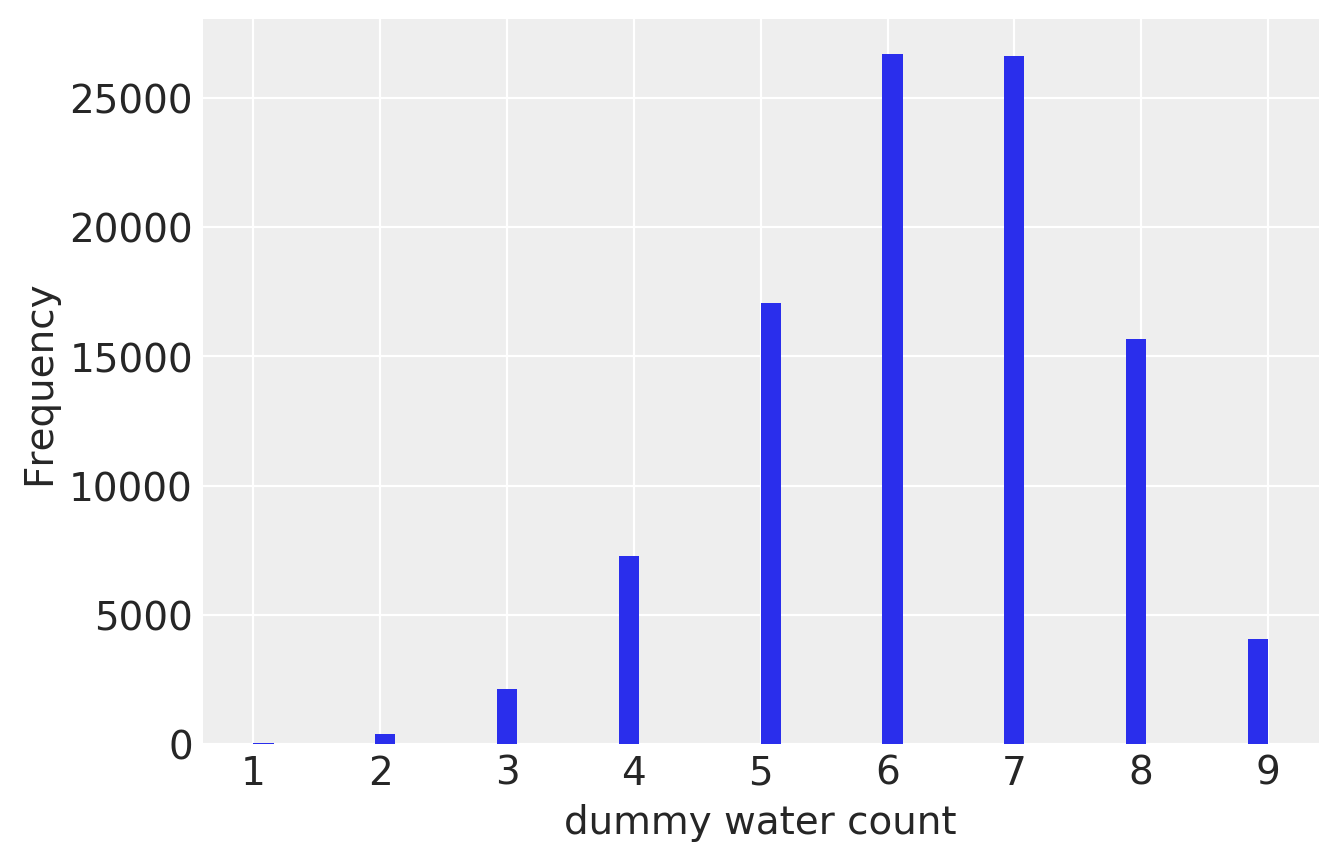

In [24]:
dummy_w = stats.binom.rvs(n=9, p=0.7, size=int(1e5))
#dummy_w = stats.binom.rvs(n=9, p=0.6, size=int(1e4))
#dummy_w = stats.binom.rvs(n=9, p=samples)
plt.hist(dummy_w, bins=50)
plt.xlabel('dummy water count', fontsize=14)
plt.ylabel('Frequency', fontsize=14);

#### Code 3.27

In [25]:
p_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)
np.random.seed(100)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

#### Code 3.28

In [26]:
birth1 = np.array([1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0, 0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0, 1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,1,0,1,1,1,0,1,1,1,1])
birth2 = np.array([0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,
1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,
0,0,0,1,1,1,0,0,0,0])

#### Code 3.29

#### Code 3.30

In [27]:
sum(birth1) + sum(birth2)

111

In [28]:
import sys, IPython, scipy, matplotlib, platform
print("""This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nArviZ {}\nNumPy {}\nSciPy {}\nMatplotlib {}\n""".format(sys.version[:5], IPython.__version__, pm.__version__, az.__version__, np.__version__, scipy.__version__, matplotlib.__version__))

This notebook was created using:
Python 3.7.1
IPython 6.2.1
PyMC3 3.7.rc1
ArviZ 0.4.0
NumPy 1.15.4
SciPy 1.1.0
Matplotlib 3.0.2

